# Exploratory Data Analysis (EDA)  
## Home Credit Default Risk

### 1. Purpose of This Notebook

This notebook focuses on **Exploratory Data Analysis (EDA)** for the Home Credit Default Risk problem.  
Its primary goal is to **understand the data before modeling**, identify potential risks to model validity, and guide downstream decisions in feature engineering, modeling, and pipeline design.

EDA is treated here as a **decision-support step**, not a purely descriptive exercise.

# 1. Imports & Configuration

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

project_root = Path("/home/priscila/Desktop/Estudos/home_credit_default_risk_mle")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.utils import memory_optimization

# 2. Data  Collection

In [2]:
homecredit_columns_description = pd.read_csv("../data/HomeCredit_columns_description.csv", encoding="cp1252")
homecredit_columns_description 

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [3]:
def retrieve_column_information(table_name:str, column_name:str) -> str:
    return homecredit_columns_description.query("Table == @table_name and Row == @column_name")["Description"].values[0]

**2.1 Dataset: Application (Train)**

In [4]:
application_train  = memory_optimization.reduce_memory_usage(pd.read_csv("../data/application_train.csv"))
print(f"Number of observations: {application_train.shape[0]}")
print(f"Number of features: {application_train.shape[1]}")
application_train.head()

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Number of observations: 307511
Number of features: 122


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


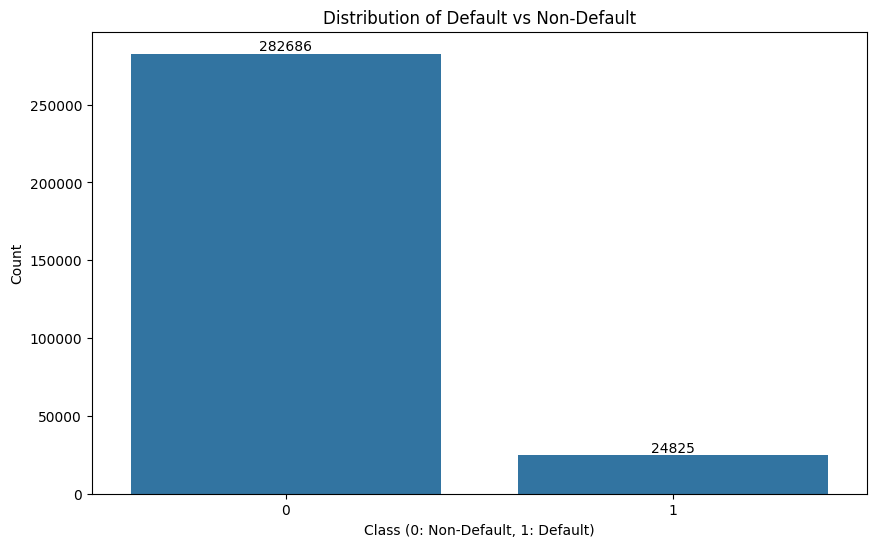

In [5]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='TARGET', data=application_train)

plt.title('Distribution of Default vs Non-Default')
plt.xlabel('Class (0: Non-Default, 1: Default)')
plt.ylabel('Count')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height,
        s=f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.show()

Column name: NAME_CONTRACT_TYPE
Column description: Identification if loan is cash or revolving


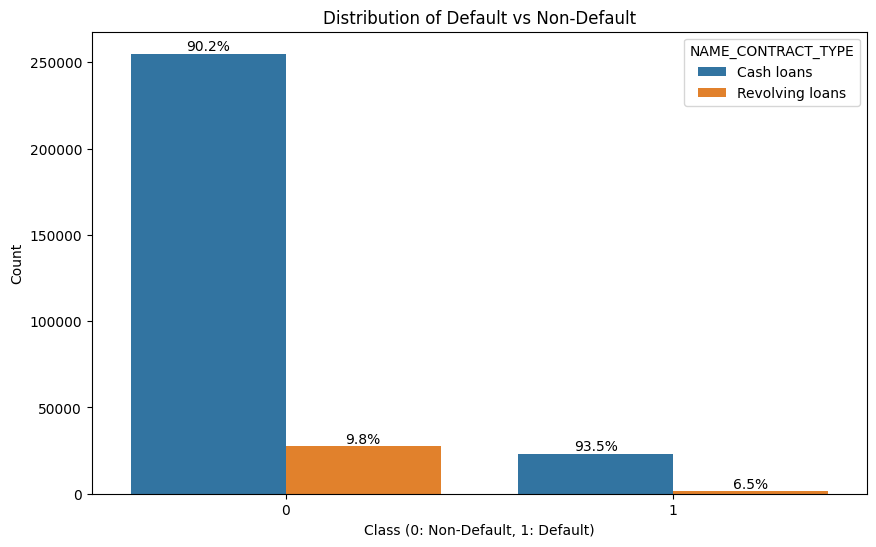

In [6]:
column_name = "NAME_CONTRACT_TYPE"
print(f"Column name: {column_name}")
print(f"Column description: {retrieve_column_information('application_{train|test}.csv', column_name)}")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='TARGET', data=application_train, hue=column_name)

plt.title('Distribution of Default vs Non-Default')
plt.xlabel('Class (0: Non-Default, 1: Default)')
plt.ylabel('Count')

totals = application_train['TARGET'].value_counts().sort_index()

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        x = p.get_x() + p.get_width() / 2
        cls = int(round(x))  # 0 or 1
        pct = 100 * height / totals[cls]
        ax.text(
            x=x,
            y=height,
            s=f'{pct:.1f}%',
            ha='center',
            va='bottom'
        )

plt.show()

Column name: CODE_GENDER
Column description: Gender of the client


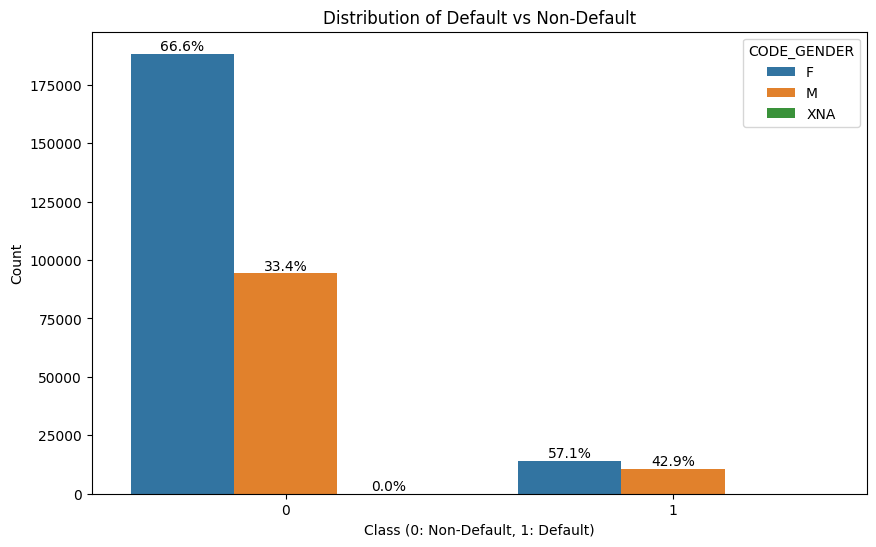

In [7]:
column_name = "CODE_GENDER"
print(f"Column name: {column_name}")
print(f"Column description: {retrieve_column_information('application_{train|test}.csv', column_name)}")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='TARGET', data=application_train, hue=column_name)

plt.title('Distribution of Default vs Non-Default')
plt.xlabel('Class (0: Non-Default, 1: Default)')
plt.ylabel('Count')

totals = application_train['TARGET'].value_counts().sort_index()

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        x = p.get_x() + p.get_width() / 2
        cls = int(round(x))  # 0 or 1
        pct = 100 * height / totals[cls]
        ax.text(
            x=x,
            y=height,
            s=f'{pct:.1f}%',
            ha='center',
            va='bottom'
        )

plt.show()

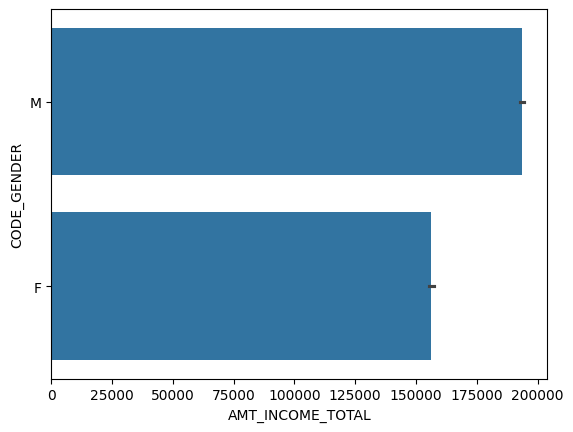

In [8]:
sns.barplot(data=application_train.query("CODE_GENDER != 'XNA'"), x="AMT_INCOME_TOTAL",   y="CODE_GENDER")
plt.show()

**2.2 Dataset: Bureau**

All client’s previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [3]:
from src.etl.bureau import load_bureau, build_bureau_features

bureau_df = load_bureau("../data/bureau.csv")
bureau_features = build_bureau_features(bureau_df)
bureau_features

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage of dataframe is 17.50 MB
Memory usage after optimization is: 9.62 MB
Decreased by 45.0%


,SK_ID_CURR,BUREAU_TOTAL_LOAN_COUNT,BUREAU_ACTIVE_LOAN_COUNT,BUREAU_CLOSED_LOAN_COUNT,BUREAU_ACTIVE_LOAN_RATIO,BUREAU_DAYS_CREDIT_MOST_RECENT,BUREAU_DAYS_CREDIT_OLDEST,BUREAU_DAYS_CREDIT_SPAN,BUREAU_OVERDUE_LOAN_RATIO,BUREAU_ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_ACTIVE_AMT_CREDIT_SUM_SUM,BUREAU_ACTIVE_DEBT_RATIO,BUREAU_ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_RECENT_1Y_LOAN_COUNT
0,100001,7,3,4,0.428467,-49,-1572,1523,0.000000,596686.5,8.840250e+05,0.674805,0.000000,2.0
1,100002,8,2,6,0.250000,-103,-1437,1334,0.375000,245781.0,4.819886e+05,0.509766,40.500000,1.0
2,100003,4,1,3,0.250000,-606,-2586,1980,0.000000,0.0,8.100000e+05,0.000000,0.000000,0.0
3,100004,2,0,2,0.000000,-408,-1326,918,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0
4,100005,3,2,1,0.666504,-62,-373,311,0.000000,568408.5,5.986260e+05,0.949707,0.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,13,2,11,0.153809,-483,-2713,2230,0.153809,163071.0,4.050000e+05,0.402588,0.000000,0.0
305807,456250,3,2,1,0.666504,-760,-1002,242,0.000000,2232040.0,2.603110e+06,0.857422,0.000000,0.0
305808,456253,4,2,2,0.500000,-713,-919,206,0.000000,1795833.0,2.610000e+06,0.687988,0.000000,0.0
305809,456254,1,0,1,0.000000,-1104,-1104,0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.0


**Dataset: Bureau Balance**

bureau_balance is a monthly snapshot of external credit behavior. In production, we aggregate this historical information up to the decision date and use it as static features for real-time or batch credit risk scoring, ensuring strict temporal cutoffs to avoid leakage.

In [2]:
bureau_balance  = memory_optimization.reduce_memory_usage(pd.read_csv("../data/bureau_balance.csv"))
print(f"Number of observations: {bureau_balance.shape[0]}")
print(f"Number of features: {bureau_balance.shape[1]}")
bureau_balance.head()

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Number of observations: 27299925
Number of features: 3


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [2]:
from src.etl.bureau_balance import load_bureau_balance,  build_bureau_balance_features

bureau_balance_df = load_bureau_balance("../data/bureau_balance.csv")
features = build_bureau_balance_features(bureau_balance_df)

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Number of observations: 27299925
Number of features: 3


In [3]:
features

,SK_ID_BUREAU,BUREAU_BALANCE_RECORD_COUNT,BUREAU_BALANCE_OLDEST_MONTH,BUREAU_BALANCE_MOST_RECENT_MONTH,BUREAU_BALANCE_MONTH_SPAN,BUREAU_BALANCE_STATUS_0_COUNT,BUREAU_BALANCE_STATUS_1_COUNT,BUREAU_BALANCE_STATUS_2_COUNT,BUREAU_BALANCE_STATUS_3_COUNT,BUREAU_BALANCE_STATUS_4_COUNT,...,BUREAU_BALANCE_DPD_MEAN,BUREAU_BALANCE_HAS_DPD,BUREAU_BALANCE_RECENT_STATUS_0,BUREAU_BALANCE_RECENT_STATUS_1,BUREAU_BALANCE_RECENT_STATUS_2,BUREAU_BALANCE_RECENT_STATUS_3,BUREAU_BALANCE_RECENT_STATUS_4,BUREAU_BALANCE_RECENT_STATUS_5,BUREAU_BALANCE_RECENT_STATUS_C,BUREAU_BALANCE_RECENT_STATUS_X
0,5001709,97,-96,0,96,0,0,0,0,0,...,0.0,0.0,False,False,False,False,False,False,True,False
1,5001710,83,-82,0,82,5,0,0,0,0,...,0.0,0.0,False,False,False,False,False,False,True,False
2,5001711,4,-3,0,3,3,0,0,0,0,...,0.0,0.0,False,False,False,False,False,False,False,True
3,5001712,19,-18,0,18,10,0,0,0,0,...,0.0,0.0,False,False,False,False,False,False,True,False
4,5001713,22,-21,0,21,0,0,0,0,0,...,0.0,0.0,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,48,-47,0,47,9,0,0,0,0,...,0.0,0.0,False,False,False,False,False,False,True,False
817391,6842885,24,-23,0,23,12,0,0,0,0,...,2.5,1.0,False,False,False,False,False,True,False,False
817392,6842886,33,-32,0,32,8,0,0,0,0,...,0.0,0.0,False,False,False,False,False,False,True,False
817393,6842887,37,-36,0,36,6,0,0,0,0,...,0.0,0.0,False,False,False,False,False,False,True,False


In [4]:
bureau_balance_df.head(10)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [5]:
bureau_balance_df.STATUS.unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [ ]:
S